## Импорт библиотек

In [1]:

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from mpl_toolkits.mplot3d import Axes3D

try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    xgboost_available = False


##Загрузка и очистка данных

In [2]:
df = pd.read_csv("encoded_bank.csv")

if "anomaly_type" in df.columns:
    df = df.drop(columns=["anomaly_type"])

target = "is_anomaly_ground_truth"
if target not in df.columns:
    raise ValueError(f"Не найден столбец '{target}' в данных.")

exclude_cols = [target, "is_suspect_unsup", "anomaly_score_synth", "transaction_id", "timestamp", "customer_id"]
features = [col for col in df.columns if col not in exclude_cols]

X = df[features]
y = df[target]

print(f"Размерность признаков: {X.shape}")
print(f"Количество аномалий: {y.sum()} из {len(y)} записей")


Размерность признаков: (30000, 135)
Количество аномалий: 904 из 30000 записей


## Разделение данных и масштабирование

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## PCA и 3D визуализация

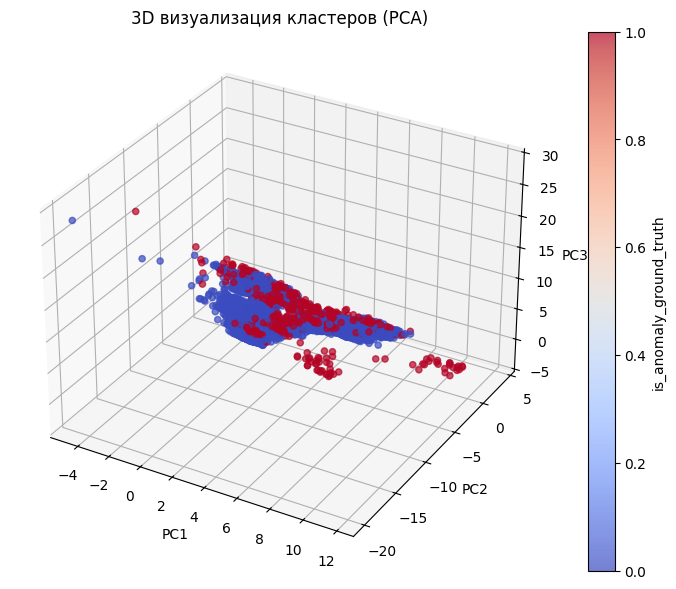

In [4]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='coolwarm', alpha=0.7)
ax.set_title("3D визуализация кластеров (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label="is_anomaly_ground_truth")
plt.show()


##Обучение RandomForest

In [5]:

rf = RandomForestClassifier(random_state=42)
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)

best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

print("\n=== RandomForest Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== RandomForest Results ===
Accuracy: 0.9981666666666666
ROC-AUC: 0.9722897651909964
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5819
           1       0.99      0.94      0.97       181

    accuracy                           1.00      6000
   macro avg       1.00      0.97      0.98      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:
 [[5818    1]
 [  10  171]]


##Отображение важности признаков RandomForest


=== ТОП-20 наиболее значимых признаков (RandomForest) ===
geo_distance_km        0.170424
device_trust_score     0.071853
country_AE             0.058113
velocity_risk_score    0.049131
ip_risk_score          0.046881
txn_count_24h          0.044357
txn_count_1h           0.040438
auth_MAGSTRIPE         0.039292
country_MD             0.036921
amount_txn_ccy         0.036402
amount_mdl             0.030878
cross_border           0.030557
hour_of_day            0.029919
amount_log_z           0.028141
is_night               0.026478
txn_amount_24h_mdl     0.018885
cluster_id_expected    0.017332
fx_rate_to_mdl         0.014106
channel_POS            0.011789
merchant_risk_score    0.011324
dtype: float64


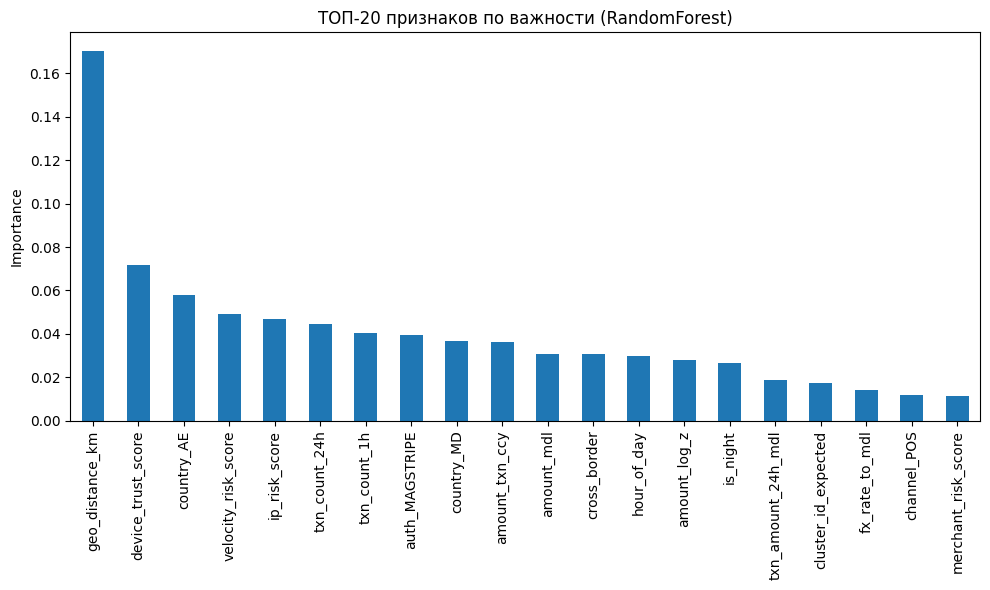

In [6]:

rf_importances = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
print("\n=== ТОП-20 наиболее значимых признаков (RandomForest) ===")
print(rf_importances.head(20))

plt.figure(figsize=(10, 6))
rf_importances.head(20).plot(kind='bar')
plt.title("ТОП-20 признаков по важности (RandomForest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


##Обучение XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Results ===
Accuracy: 0.9983333333333333
ROC-AUC: 0.975052196130223
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5819
           1       0.99      0.95      0.97       181

    accuracy                           1.00      6000
   macro avg       1.00      0.98      0.99      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:
 [[5818    1]
 [   9  172]]

=== ТОП-20 наиболее значимых признаков (XGBoost) ===
cross_border               0.266844
auth_MAGSTRIPE             0.171969
txn_count_1h               0.118097
txn_count_24h              0.095971
country_AE                 0.093264
geo_distance_km            0.061787
device_trust_score         0.041808
hour_of_day                0.031826
currency_MDL               0.021153
currency_RON               0.018898
region_Orhei               0.007417
ip_risk_score              0.006819
amount_txn_ccy             0.005548
issuer_OTP Bank Moldova 

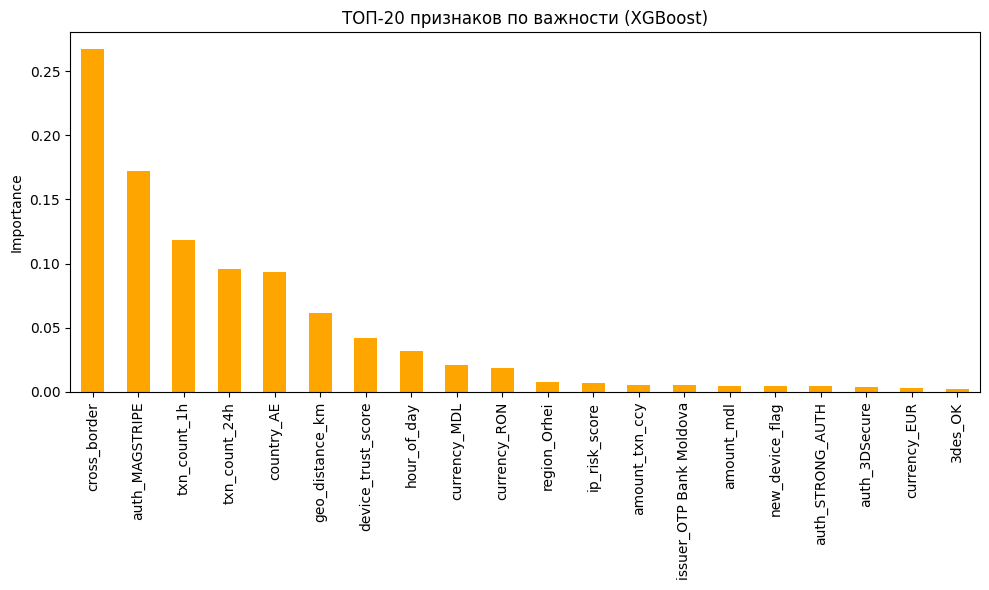

In [7]:
if xgboost_available:
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_params = {
        "n_estimators": [100, 200],
        "max_depth": [5, 10],
        "learning_rate": [0.05, 0.1]
    }
    xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, n_jobs=-1, verbose=1)
    xgb_grid.fit(X_train_scaled, y_train)

    best_xgb = xgb_grid.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test_scaled)

    print("\n=== XGBoost Results ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))
    print(classification_report(y_test, y_pred_xgb))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

    xgb_importances = pd.Series(best_xgb.feature_importances_, index=features).sort_values(ascending=False)
    print("\n=== ТОП-20 наиболее значимых признаков (XGBoost) ===")
    print(xgb_importances.head(20))

    plt.figure(figsize=(10, 6))
    xgb_importances.head(20).plot(kind='bar', color='orange')
    plt.title("ТОП-20 признаков по важности (XGBoost)")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


##Сохранение обученных моделей

In [8]:
os.makedirs("models", exist_ok=True)
joblib.dump(best_rf, "models/random_forest_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

if xgboost_available:
    joblib.dump(best_xgb, "models/xgboost_model.pkl")

print("\n✅ Модели успешно обучены и сохранены в папку /models")



✅ Модели успешно обучены и сохранены в папку /models


##Функции загрузки и предсказания моделей

In [9]:
import joblib
import numpy as np
import pandas as pd
import os

def load_models():
    rf_model = joblib.load("models/random_forest_model.pkl")
    scaler = joblib.load("models/scaler.pkl")

    xgb_model = None
    xgb_path = "models/xgboost_model.pkl"
    if os.path.exists(xgb_path):
        xgb_model = joblib.load(xgb_path)

    return rf_model, xgb_model, scaler


def predict_anomaly(input_data: dict, dataset_path="encoded_bank.csv"):
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Файл '{dataset_path}' не найден.")

    df = pd.read_csv(dataset_path)
    exclude_cols = ["is_anomaly_ground_truth", "is_suspect_unsup",
                    "anomaly_score_synth", "transaction_id",
                    "timestamp", "customer_id", "anomaly_type"]
    features = [col for col in df.columns if col not in exclude_cols]

    base_row = df.loc[0, features].copy()
    for key, value in input_data.items():
        if key in base_row.index:
            base_row[key] = value
        else:
            print(f"⚠️ Предупреждение: поле '{key}' отсутствует среди признаков и будет пропущено")

    X_input = pd.DataFrame([base_row])

    rf_model, xgb_model, scaler = load_models()
    X_scaled = scaler.transform(X_input)

    # RandomForest
    rf_pred = rf_model.predict(X_scaled)[0]
    rf_prob = rf_model.predict_proba(X_scaled)[0][1]
    print("=== RandomForest ===")
    print(f"Предсказание: {'Аномальная' if rf_pred == 1 else 'Нормальная'} транзакция")
    print(f"Вероятность аномалии: {rf_prob:.2%}")

    # XGBoost
    if xgb_model:
        xgb_pred = xgb_model.predict(X_scaled)[0]
        xgb_prob = xgb_model.predict_proba(X_scaled)[0][1]
        print("\n=== XGBoost ===")
        print(f"Предсказание: {'Аномальная' if xgb_pred == 1 else 'Нормальная'} транзакция")
        print(f"Вероятность аномалии: {xgb_prob:.2%}")


##Пример предсказания

In [10]:

example_transaction = {
   "amount_mdl": 500000.0,
   "cross_border": 0,
   "hour_of_day": 2,
   "geo_distance_km": 2000,
   "is_night": 1,
   "new_device_flag": 1,
   "device_trust_score": 0.1,
   "country_AE": 1,
   "velocity_risk_score": 0.8,
   "ip_risk_score": 0.75
}

predict_anomaly(example_transaction)


=== RandomForest ===
Предсказание: Аномальная транзакция
Вероятность аномалии: 79.28%

=== XGBoost ===
Предсказание: Аномальная транзакция
Вероятность аномалии: 99.81%
